In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

from utils import fNN, scoreNN, QAE_NN_smooth_minibatch_Adadelta
from utils import f, score, QAE_linear_smooth

from sklearn.linear_model import LinearRegression,  HuberRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

# Function to generate the data

In [2]:
def generate_data(i, d):
    np.random.seed(i)
    
    n = 1000
    ntest = 1000

    theta = np.random.uniform(size=d)
    # ====================
    X = np.random.normal(size=d*n).reshape((n, len(theta)))
    Y = X.dot(theta) + np.random.normal(0, .4, n)*np.abs(X[:, 0])
    # ====================
    
    # ====================
    Xtrain = X[:n//2]
    Xcalib = X[n//2:]
    
    ytrain = Y[:n//2]
    ycalib = Y[n//2:]
    # ====================

    # ====================
    Xtest = np.random.normal(size=len(theta)*ntest).reshape((ntest, len(theta)))
    ber_test = np.random.binomial(size=ntest, n=1, p= 0.95)
    ytest = Xtest.dot(theta) + np.random.normal(0, .4, ntest)*np.abs(Xtest[:, 0])
    # ====================

    XXtrain = np.concatenate((np.ones((Xtrain.shape[0],1)), Xtrain), axis = 1)
    XXcalib = np.concatenate((np.ones((Xcalib.shape[0],1)), Xcalib), axis = 1)
    XXtest = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis = 1)
    
    return ytrain, ycalib, ytest, XXtrain, XXcalib, XXtest, theta

# Neural Net builder

In [3]:
# Building a model
class network(nn.Module):
    def __init__(self, D_in=2, H=10, D_out=1, Hn=2):
        super().__init__()
        self.Hn = Hn # Number of hidden layer
        self.activation = nn.ReLU() # Activation function
        
        self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation]) # First hidden layer
        for i in range(self.Hn - 1):
            self.layers.extend([nn.Linear(H, H), self.activation]) # Add hidden layer
        self.layers.append(nn.Linear(H, D_out)) # Output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def trainer(model, criterion, optimizer, dataloader, epochs=5):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    for epoch in range(epochs):  # for each epoch
        losses = 0
        for X, y in dataloader:  # for each batch
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            losses += loss.item()       # Add loss for this batch to running total
        train_loss.append(losses / len(dataloader))  # loss = total loss in epoch / number of batches = loss per batch
    return train_loss

# Data set

In [4]:
# generate data
ytrain, ycalib, ytest, Xtrain, Xcalib, Xtest, theta_true = generate_data(1, 1)

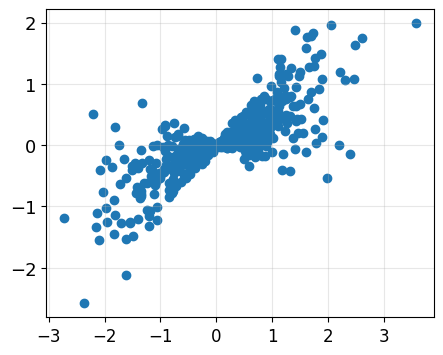

In [5]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=12)
plt.subplots(figsize=(5, 4))

plt.scatter(Xtrain[:, 1], ytrain)
plt.grid(alpha=.3)

# EffOrt NN

In [6]:
# learning of the NN (step 1 of EffOrt)
model_QAE = network(D_in=2, H=10, D_out=1, Hn=1)

n_iter = 100
alpha = .1 # 1-coverage
epsi = .1 # smoothing parameter

opt_track = QAE_NN_smooth_minibatch_Adadelta(Xtrain[:, None], ytrain, model_QAE, len(ytrain), alpha, n_iter, epsi)

/home/ph/Documents/LPSM/quantile_learning/ICML_code/utils_ICML.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(param.data - delta_param[sss:sss+len(weights[i])].reshape((param.size())), dtype=torch.float32)


In [7]:
# calibration (step 2 of EffOrt)
scores_QAE = scoreNN(Xcalib, ycalib, model_QAE)
r = int(np.ceil( (len(scores_QAE) + 1)*(1-alpha) ))
q_QAE = np.sort(scores_QAE)[r-1]

# contruction of the set (step 3 of EffOrt)
ytest_QAE = fNN(Xtest, model_QAE)

print('size:', 2*q_QAE) 
print('coverage:', np.mean( (ytest <= (ytest_QAE+q_QAE))*(ytest >= (ytest_QAE-q_QAE)) ))

size: 1.4072333572564426
coverage: 0.901


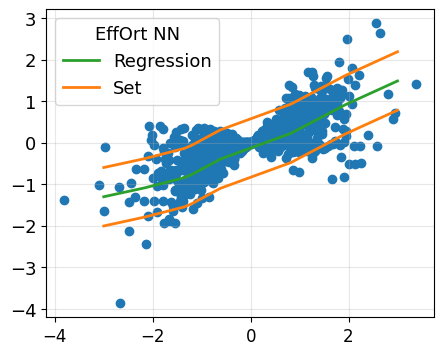

In [8]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=12)
plt.subplots(figsize=(5, 4))

xplot = np.linspace(-3, 3, 10000).reshape((-1, 1))
xxplot = np.vstack((np.ones(len(xplot)).T, xplot.T)).T
yplot_QAE = fNN(xxplot, model_QAE)

plt.plot(xplot, yplot_QAE, color='C2',linestyle='-', lw=2)
plt.plot(xplot, yplot_QAE + q_QAE, color='C1',linestyle='-', lw=2)
plt.plot(xplot, yplot_QAE - q_QAE, color='C1',linestyle='-', lw=2)
plt.scatter(Xtest[:, 1], ytest)
plt.grid(alpha=.3)

plt.legend(['Regression','Set'], title="EffOrt NN");

# EffOrt Linear

In [9]:
# learning of the Linear function (step 1 of EffOrt)
n_iter = 100
stepsize = np.arange(1, n_iter+1)**(-.6)
alpha = .1
epsi = .1

theta_lQAE, _ = QAE_linear_smooth(Xtrain, ytrain, alpha, stepsize, n_iter, epsi)

In [10]:
# calibration (step 2 of EffOrt)
scores = score(Xcalib, ycalib, theta_lQAE)
r = int(np.ceil( (len(scores) + 1)*(1-alpha) ))
q_lQAE = np.sort(scores)[r-1]

# contruction of the set (step 3 of EffOrt)
ytest_lQAE = Xtest.dot(theta_lQAE).ravel()

print('size:', 2*q_lQAE) 
print('coverage:', np.mean( (ytest <= ytest_lQAE+q_lQAE)*(ytest >= ytest_lQAE-q_lQAE) ))

size: 1.292350316723081
coverage: 0.893


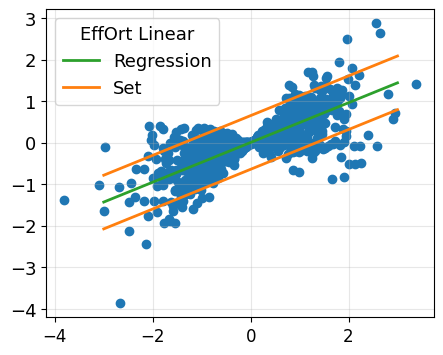

In [11]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=12)
plt.subplots(figsize=(5, 4))

xplot = np.linspace(-3, 3, 10000).reshape((-1, 1))
xxplot = np.vstack((np.ones(len(xplot)).T, xplot.T)).T
yplot_lQAE = xxplot.dot(theta_lQAE).ravel()

plt.plot(xplot, yplot_lQAE, color='C2',linestyle='-', lw=2)
plt.plot(xplot, yplot_lQAE + q_lQAE, color='C1',linestyle='-', lw=2)
plt.plot(xplot, yplot_lQAE - q_lQAE, color='C1',linestyle='-', lw=2)
plt.scatter(Xtest[:, 1], ytest)
plt.grid(alpha=.3)

plt.legend(['Regression','Set'], title="EffOrt Linear");

# Linear Split CP (Standard)

In [12]:
# learning step
reg = LinearRegression(fit_intercept=False).fit(Xtrain, ytrain)
scores_reg = np.abs(reg.predict(Xcalib)- ycalib)

# calibration step
k = int(np.ceil( (len(scores_reg) + 1)*(1-alpha) ))
q_reg = np.sort(scores_reg)[k-1]

# contruction of the set
ytest_reg = reg.predict(Xtest)

print('size:', 2*q_reg) 
print('coverage:', np.mean( (ytest <= ytest_reg+q_reg)*(ytest >= ytest_reg-q_reg) ))

size: 1.2633089261601262
coverage: 0.888


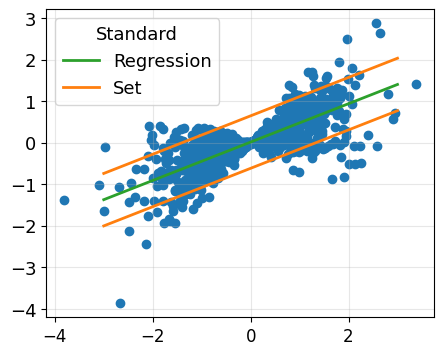

In [13]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=12)
plt.subplots(figsize=(5, 4))

xplot = np.linspace(-3, 3, 10000).reshape((-1, 1))
xxplot = np.vstack((np.ones(len(xplot)).T, xplot.T)).T
yplot_reg = reg.predict(xxplot)

plt.plot(xplot, yplot_reg, color='C2',linestyle='-', lw=2)
plt.plot(xplot, yplot_reg + q_reg, color='C1',linestyle='-', lw=2)
plt.plot(xplot, yplot_reg - q_reg, color='C1',linestyle='-', lw=2)
plt.scatter(Xtest[:, 1], ytest)
plt.grid(alpha=.3)

plt.legend(['Regression','Set'], title="Standard");

# Robust linear Split CP (Robust)

In [14]:
# learning step
reg_huber = HuberRegressor(fit_intercept=False).fit(Xtrain, ytrain)
scores_huber = np.abs(reg_huber.predict(Xcalib)- ycalib)

# calibration step
k = int(np.ceil( (len(scores_huber) + 1)*(1-alpha) ))
q_huber = np.sort(scores_huber)[k-1]

# construction of the set
ytest_huber = reg_huber.predict(Xtest)

print('size:', 2*q_huber) 
print('coverage:', np.mean( (ytest <= ytest_huber+q_huber)*(ytest >= ytest_huber-q_huber) ))

size: 1.2647156951814724
coverage: 0.889


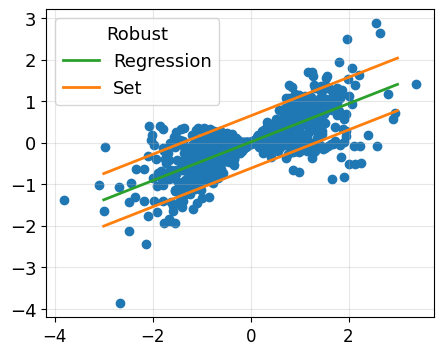

In [15]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rc('xtick', labelsize=12)
plt.subplots(figsize=(5, 4))

xplot = np.linspace(-3, 3, 10000).reshape((-1, 1))
xxplot = np.vstack((np.ones(len(xplot)).T, xplot.T)).T
yplot_huber = reg_huber.predict(xxplot)

plt.plot(xplot, yplot_huber, color='C2',linestyle='-', lw=2)
plt.plot(xplot, yplot_huber + q_huber, color='C1',linestyle='-', lw=2)
plt.plot(xplot, yplot_huber - q_huber, color='C1',linestyle='-', lw=2)
plt.scatter(Xtest[:, 1], ytest)
plt.grid(alpha=.3)

plt.legend(['Regression','Set'], title="Robust");